dataset source: https://www.microsoft.com/en-us/download/details.aspx?id=54765

In [1]:
path = "../../data/kagglecatsanddogs_5340/PetImages"

In [ ]:
import os, sys, shutil

# Move and organise data
def create_dataset_directories(base_dir: str) -> None:
    print("Start creation of dataset directories...")

    if not os.path.exists(base_dir):
        os.mkdir(base_dir)

    directories = ["train", "validation", "test"]
    for directory in directories:
        sub_dir = os.path.join(base_dir, directory)
        os.mkdir(sub_dir)
        os.mkdir(os.path.join(sub_dir, "cats"))
        os.mkdir(os.path.join(sub_dir, "dogs"))

    print("Done")

def copy_data(src: str, dst: str, example_name: str, fnames: list[str]) -> None:
    print("Copying...")
    for fname in fnames:
        print(f"Copying {fname} to {dst}")
        shutil.copyfile(
            os.path.join(src, fname),
            os.path.join(dst, example_name + "." + fname)
        )

In [ ]:
import re

fnames_cats = [f for f in os.listdir(path + "/Cat") if re.match(r"[0-9]+.*\.jpg", f)]
fnames_dogs = [f for f in os.listdir(path + "/Dog") if re.match(r"[0-9]+.*\.jpg", f)]

In [ ]:
len(fnames_dogs)

In [ ]:
12500*0.8

In [ ]:
train_fnames_cats = fnames_cats[:8000]
val_fnames_cats = fnames_cats[8000:10000]
test_fnames_cats = fnames_cats[10000:]

train_fnames_dogs = fnames_dogs[:8000]
val_fnames_dogs = fnames_dogs[8000:10000]
test_fnames_dogs = fnames_dogs[10000:]

In [6]:
# destination = "../../data/cats_vs_dogs"
## for my current directory:
destination = "." 

In [ ]:
create_dataset_directories(destination)

copy_data(path + "/Cat", f"{destination}/train/cats", "cat", train_fnames_cats)
copy_data(path + "/Dog", f"{destination}/train/dogs", "dog", train_fnames_dogs)

copy_data(path + "/Cat", f"{destination}/validation/cats", "cat", val_fnames_cats)
copy_data(path + "/Dog", f"{destination}/validation/dogs", "dog", val_fnames_dogs)

copy_data(path + "/Cat", f"{destination}/test/cats", "cat", test_fnames_cats)
copy_data(path + "/Dog", f"{destination}/test/dogs", "dog", test_fnames_dogs)

## Remove corrupted images

In [ ]:
# Method 1

import shutil
import os
import time
from PIL import Image


def extract_corrupt_img_files(dir_path):
    """
    Gets corrupted image files within a directory
        Arguments:
            dir_path: a string representing the path for the target directory

        Returns:
            a list of the paths for the corrupted image files
    """
    i = 0
    beg = time.time()
    corrupted = []
    for filename in os.listdir(dir_path):
        i += 1
        if (i % 50 == 0):
            print(i, end = " ")
        if (i % 1000 == 0):
            print()
        try:
            img = Image.open(dir_path + "/" + filename)
        except:
            corrupted.append(filename)
            os.remove(dir_path + "/" + filename)
            continue
    end = time.time()
    print()
    print("*" * 50)
    print("\nTASK FINISHED IN " + str(end - beg) + " seconds ")
    print("{} corrupted files found and removed in {}".format(len(corrupted), dir_path))
    print("*" * 50)
    return corrupted

extract_corrupt_img_files(f"{destination}/test/cats")

In [ ]:
# Method 2

from pathlib import Path
import imghdr

data_dir = f"{destination}/test/dogs"
image_extensions = [".png", ".jpg"] # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image and will be removed")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow and will be removed")

In [ ]:
# Method 3

from pathlib import Path
import imghdr
import tensorflow as tf

test_dir = f"{destination}/test"
img_link = list(Path(validation_dir).glob(r"**/*.jpg"))

count_num = 0
for lnk in img_link:
    binary_img = open(lnk, "rb")
    find_img = tf.compat.as_bytes("JFIF" in binary_img.peek(10)) # The JFIF is a JPEG File Interchange Format (JFIF). It is standard which
    if not find_img:
        count_num += 1
        os.remove(str(lnk))
print("Total %d pcs omage delete from Dataset" % count_num)

In [ ]:
# Method 4
import glob

img_paths = glob.glob(os.path.join(f"{destination}/train/", "*/*.*")) # assuming you point to the directory containing the label folders

bad_paths = []

for image_path in img_paths:
    try:
        img_bytes = tf.io.read_file(image_path)
        decoded_img = tf.io.decode_image(img_bytes)
    except tf.errors.InvalidArgumentError as e:
        print(f"Found bad path {image_path} ... {e}")
        bad_paths.append(image_path)
        os.remove(image_path)

    # print(f"{image_path}: OK")

print("BAD PATHS (removed):")
for bad_path in bad_paths:
    print(f"{bad_path}")

## Build your model

In [1]:
from keras import layers
from keras import models


model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation="relu"),

    layers.Dense(1, activation="sigmoid")
])


model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

c:\Users\yulic\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [2]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# process the data

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = f"{destination}/train/"
validation_dir = f"{destination}/validation"

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode="binary"
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode="binary"
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
epochs = 15
len(train_generator) // epochs # 31 step (iteration) in epoch 

4

In [9]:
# model sees each data point once
epochs = 15

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator) // epochs, # len(train_generator)//epochs
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) // epochs 
)

Epoch 1/15


c:\Users\yulic\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.4979 - loss: 0.7802 - val_accuracy: 0.5625 - val_loss: 0.6821
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.4625 - loss: 0.7007 - val_accuracy: 0.5000 - val_loss: 0.6922
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.4427 - loss: 0.6962 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.4917 - loss: 0.6940 - val_accuracy: 0.3594 - val_loss: 0.6937
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4677 - loss: 0.6932 - val_accuracy: 0.4219 - val_loss: 0.6943
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5031 - loss: 0.6926 - val_accuracy: 0.5781 - val_loss: 0.6919
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5052 - loss: 0.6921 - val_accuracy: 0.5156 - val_loss: 0.6921
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5146 - loss: 0.6917 - val_accuracy: 0.5312 - val_loss: 0.6891
Epo

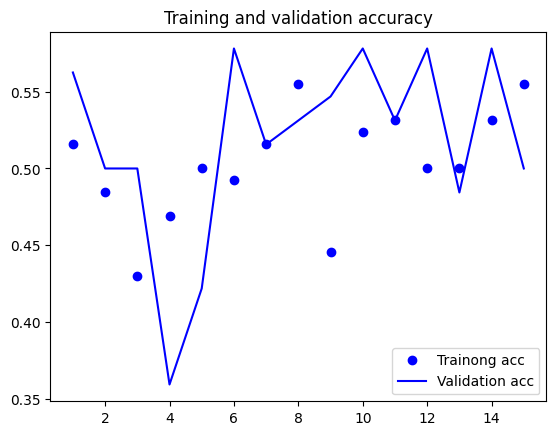

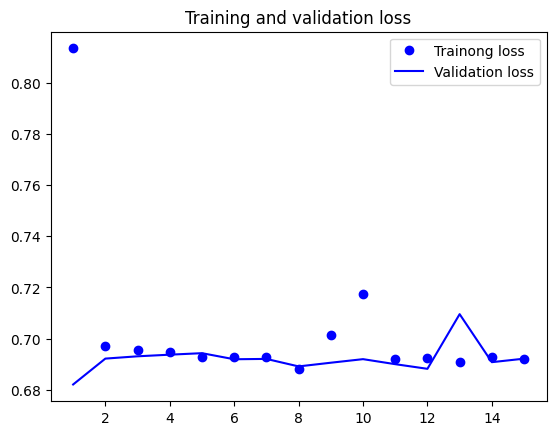

In [10]:
import matplotlib.pyplot as plt


acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Trainong acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Trainong loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

## Data Augmentation

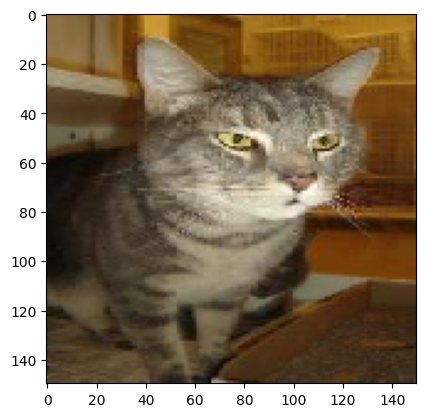

In [11]:
# deprecated

import os
import matplotlib.pyplot as plt

from more_itertools import take
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_cats_dir = f"{destination}/train/cats"

fnames = [
    os.path.join(train_cats_dir, fname)
    for fname in os.listdir(train_cats_dir)
]

img_path = fnames[92]
img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
plt.imshow(image.array_to_img(x[0]))

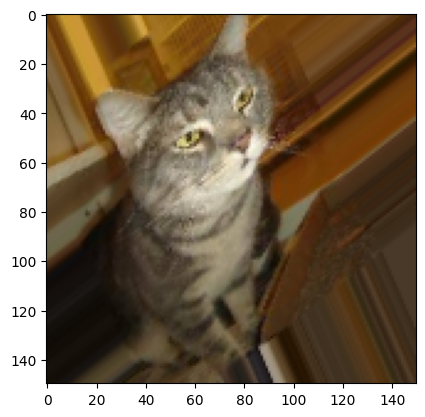

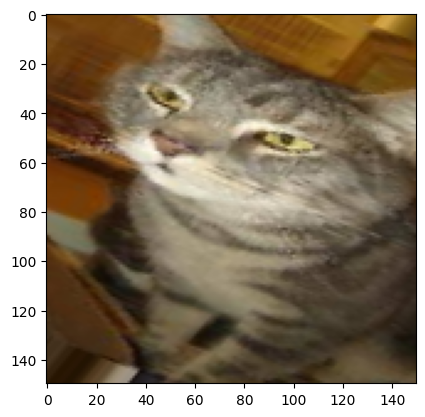

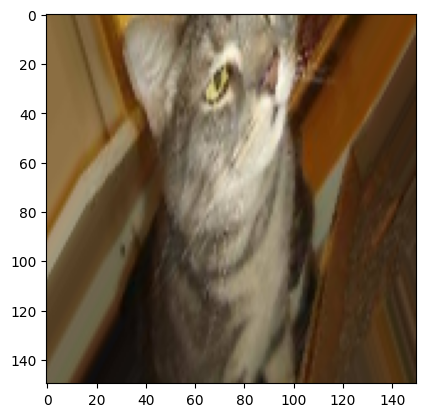

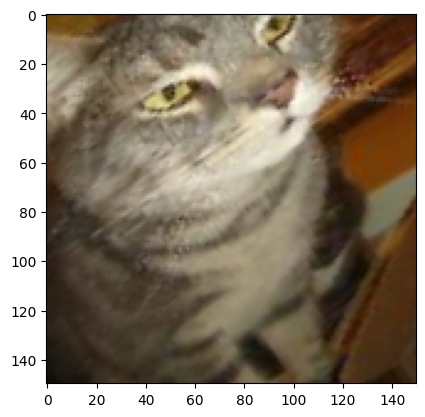

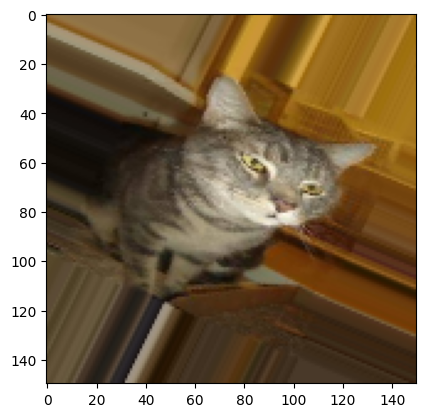

In [12]:
for batch in take(5, datagen.flow(x, batch_size=1)):
    plt.figure()
    imgplot = plt.imshow(image.array_to_img(batch[0]))

plt.show()

Min and max pixel values: 0.0 0.98981315


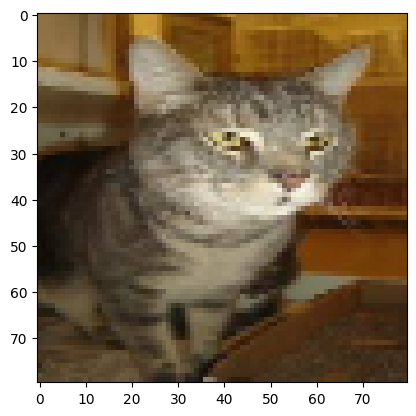

In [13]:
# keras preprocessing layers

import tensorflow as tf

IMG_SIZE = 80

# You can use the Keras preprocessing layers to resize your images to a consistent shape
# (with tf.keras.layers.Resizing), and to rescale pixel values (with tf.keras.layers.Rescaling)

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])

result = resize_and_rescale(x)
_ = plt.imshow(result[0])

print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

In [14]:
# You can use the Keras preprocessing layers for data augmentation as well,
# such as tf.layers.RandomFlip and tf.keras.layers.RandomRotation

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [15]:
# Add the image to a batch
image = tf.cast(tf.expand_dims(result[0], 0), tf.float32)

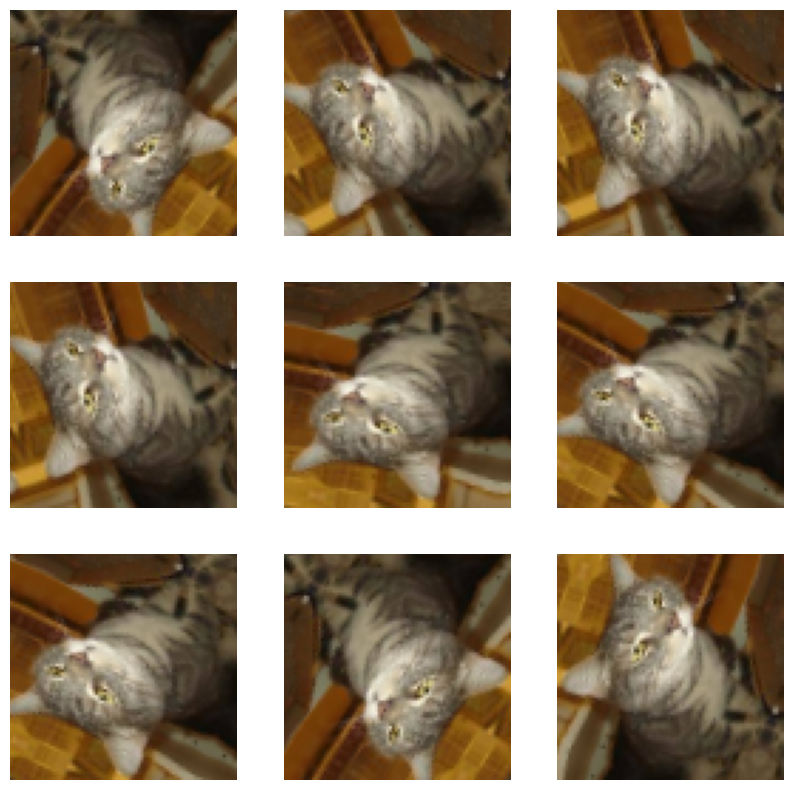

In [16]:
# https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

### Add the preprocessing layers to the model

There are ***two important points*** to be aware of in this case:

1. Data augmentation will run on-device, sinchronously with the rest of the layers, and benefit from GPU acceleration.
2. When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model.

If you later deploy this model, it will automatically standardize iamges (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.


You will see some improvement in accuracy if you remove the RandomFlip and RandomRotation layers because you make the problem easier. 

However, as you want the network to predict well on a wide variation of  image quality and properties, using augmentation can help your resulting netwirk become more powerful.

https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/

In [17]:
model_augmented = tf.keras.Sequential([
    # Add the preprocessing layers you created earlier
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation="relu"),

    layers.Dense(1, activation="sigmoid")
])

model_augmented.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

c:\Users\yulic\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=batch_size,
    color_mode="rgb"
)

# train_data = train_data.repeat(2)

validation_data = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(150, 150),
    batch_size=batch_size,
    color_mode="rgb"
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [19]:
type(train_data)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [20]:
# train_data.file_paths
train_data.class_names # if < 0.5 = cats, if > 0.5 = dogs

['cats', 'dogs']

In [21]:
epochs = 15

history = model_augmented.fit(
    train_data,
    steps_per_epoch=len(train_data) // epochs,
    epochs=epochs,
    validation_data=validation_data
)

Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.5302 - loss: 0.7232 - val_accuracy: 0.5020 - val_loss: 0.6933
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4656 - loss: 0.6947 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5167 - loss: 0.6954 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5292 - loss: 0.6943 - val_accuracy: 0.5270 - val_loss: 0.6927
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.4938 - loss: 0.6947 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5365 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.4688 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4927 - loss: 0.6964 - val_accuracy: 0.5000 - val_loss:

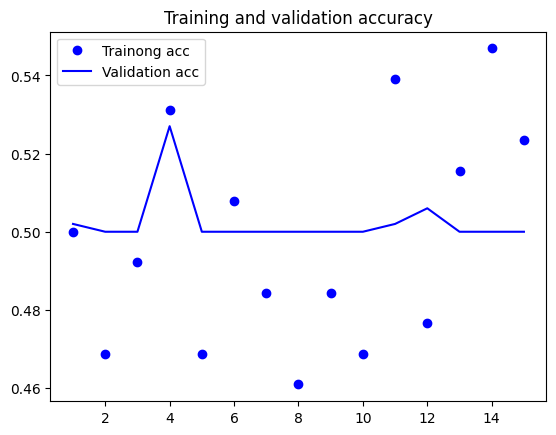

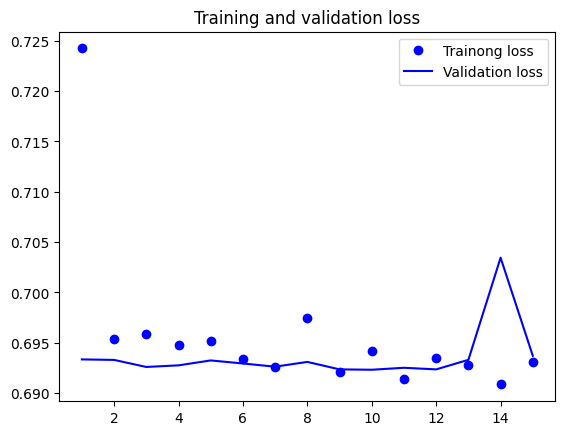

In [22]:
import matplotlib.pyplot as plt


acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Trainong acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Trainong loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [23]:
test_dir = f"{destination}/test"
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=batch_size,
    color_mode="rgb"
)

Found 1000 files belonging to 2 classes.


In [24]:
model.evaluate(test_data)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5262 - loss: 1.8536


[1.914646029472351, 0.527999997138977]

In [25]:
model_augmented.evaluate(test_data)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5266 - loss: 0.6921


[0.69366055727005, 0.5]

In [26]:
# data loading and preprocessing must be the same as in training!
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode="binary"
)

model.evaluate(test_generator)

Found 1000 images belonging to 2 classes.
 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6250 - loss: 0.6851

c:\Users\yulic\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5064 - loss: 0.6923


[0.6925762891769409, 0.5049999952316284]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


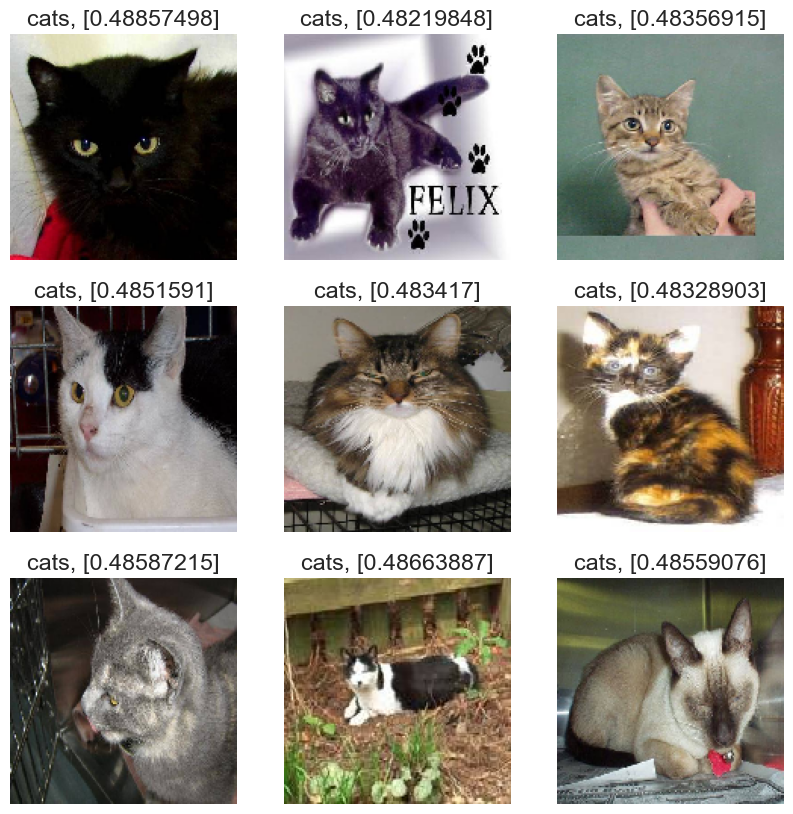

In [32]:
from tensorflow.keras.preprocessing import image

fnames = [
    os.path.join(test_dir + "/cats", fname)
    for fname in os.listdir(test_dir + "/cats")
]

plt.figure(figsize=(10, 10))
for i in range(9):
    img_path = fnames[i]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.array_to_img(x[0]))
    prediction = model_augmented.predict(x)[0]
    predicted_lable = test_data.class_names[1] if prediction > 0.5 else test_data.class_names[0]
    plt.title(f"{predicted_lable}, {prediction}")
    plt.axis("off")

In [28]:
# Create a confusion matrix
import numpy as np

predictions = np.array([])
labels = np.array([])

for x, y in test_data:
    prediction = model_augmented.predict(x)
    classes_x = tf.constant((prediction > 0.5).astype("int32").reshape(1, -1)[0])
    predictions = np.concatenate([predictions, classes_x])
    labels = np.concatenate([labels, y])

print(len(labels))
print(len(predictions))
confusion_matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
confusion_matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

array([[500,   0],
       [500,   0]], dtype=int32)

tf.Tensor(
[[500   0]
 [500   0]], shape=(2, 2), dtype=int32)


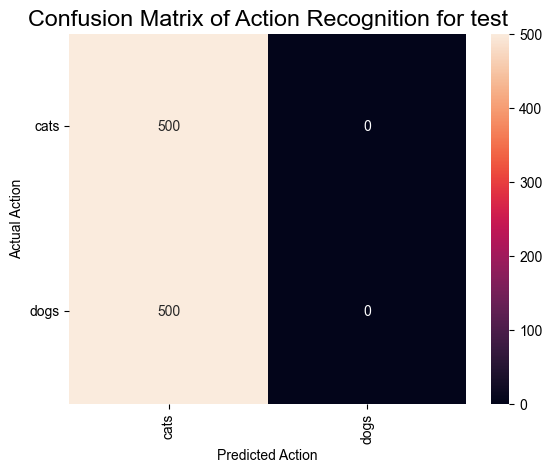

In [30]:
import seaborn as sns

def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    print(cm)
    ax = sns.heatmap(cm, annot=True, fmt="g")
    sns.set(rc={"figure.figsize":(6, 6)})
    sns.set(font_scale=1.4)
    ax.set_title("Confusion Matrix of Action Recognition for " + ds_type)
    ax.set_xlabel("Predicted Action")
    ax.set_ylabel("Actual Action")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)


plot_confusion_matrix(labels, predictions, test_data.class_names, "test")